In [1]:
from __future__ import print_function
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')
from __future__ import division
import matplotlib.pyplot as plt
#plt.rc('font', family='Arial')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
#sns.set(font='Arial')
from sigr.parse_log import parse_log
from sigr.module import Module, Load, Init
import mxnet as mx
import sigr.data_s21 as s21
import os
from sigr import CACHE
import joblib as jb
from nose.tools import assert_equal
from time import time
from sigr import constant
from sigr.evaluation import InterSubjectEvaluation, Exp


def compare(exps, folds=range(10)):
    from IPython.display import display
    df = []
    evaluation = InterSubjectEvaluation(batch_size=1000)
    for fold in folds:
        df.append(evaluation.compare(exps, fold))
    df = pd.DataFrame(df, columns=[exp.name for exp in exps])
    df.plot.bar(rot=0)
    plt.xlabel('Subject')
    plt.ylabel('Accuracy (%)')
    display(df.mean())

In [2]:
import scipy.io as sio


d = sio.loadmat('../.cache/csl/subject1/session5/gest0.mat')

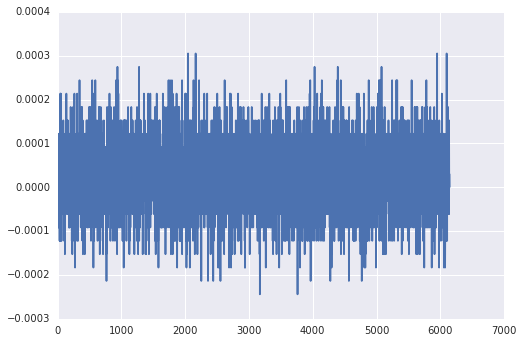

In [3]:
plt.plot(d['gestures'][0, 0][0])

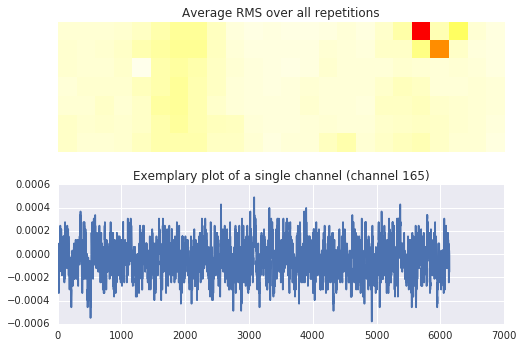

In [25]:
# example code to load data from the csl-hdemg dataset

import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from math import sqrt

# load the data
mat = d#sio.loadmat('../subject5/session3/gest11.mat')
gestures = mat['gestures']

#compute RMS
rms = np.zeros(168)
for i in range(0,10):
 trial = gestures[i,0]
 #deleting edge channels
 trial = np.delete(trial,np.s_[7:192:8],0)
 for c in range(0,trial.shape[0]):
     #computing mean rms over all repetitions
     rms[c] += np.linalg.norm(trial[c,:]) / sqrt(len(trial[c,:])) / 10

#reshaping to the correct shape
rms = np.reshape(rms,(24,7))
rms = np.flipud(np.transpose(rms))

#plot data
plt.subplot(211)
plt.imshow(rms, cmap='hot_r', interpolation='nearest', vmin=0, vmax=0.0035)
plt.axis('off')
plt.title('Average RMS over all repetitions')
plt.subplot(212)
plt.plot(gestures[9,0][164,:])
plt.title('Exemplary plot of a single channel (channel 165)')
plt.show()


In [40]:
params = mx.nd.load('../.cache/sigr-inter-adabn-0-v955.75.2/model-0030.params')
n = 8
for i in range(1, n):
    for j in range(i):
        v = params['arg:block%d_dense%d_zero' % (i + 1, j + 1)].asnumpy().flat[0]
        print('%6.2f ' % v, end='')
    v = params['arg:block%d_dense%d_one' % (i + 1, i + 1)].asnumpy().flat[0]
    print('%6.2f' % v)

 -0.47   0.79
 -0.12   0.12   0.83
 -0.15   0.14   0.04   0.59
  0.02   0.05   0.06   0.14   0.78
  0.01  -0.02  -0.15   0.10  -0.01   0.89
  0.03   0.06   0.04   0.09  -0.11  -0.07   0.85
  0.09  -0.08   0.14   0.20   0.04  -0.03   0.03   0.87


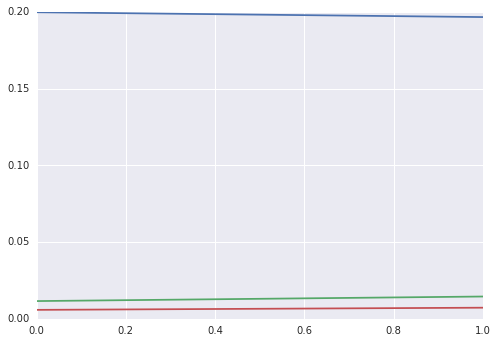

In [38]:
for path in [
    '../.cache/sigr-inter-adabn-0-v955.74.17/model-%04d.params',
    #'../.cache/sigr-inter-adabn-0-v955.74.19/model-%04d.params',
    #'../.cache/sigr-inter-adabn-0-v955.74.20/model-%04d.params',
    #'../.cache/sigr-inter-adabn-0-v955.74.21/model-%04d.params',
    '../.cache/sigr-inter-adabn-0-v955.74.22/model-%04d.params',
]:
    y = []
    for epoch in range(1, 3):
        params = mx.nd.load(path % epoch)
        y.append(np.mean(np.std([params['arg:pixel1_fc%d_weight' % i].asnumpy() for i in range(128)], axis=0)))
    plt.plot(y)

In [32]:
params = mx.nd.load('../.cache/sigr-inter-adabn-0-v955.71/model-0060.params')
print(np.mean(np.std([params['arg:pixel1_fc%d_weight' % i].asnumpy() for i in range(128)], axis=0)))
print(np.mean(np.linalg.norm([params['arg:pixel1_fc%d_weight' % i].asnumpy() for i in range(128)], axis=0)))

0.00212612
0.352362


In [48]:
params = mx.nd.load('../.cache/sigr-inter-adabn-0-v955.73/model-0060.params')
print(np.mean(np.std([params['arg:pixel1_fc%d_weight' % i].asnumpy() for i in range(128)], axis=0)))
print(np.mean(np.linalg.norm([params['arg:pixel1_fc%d_weight' % i].asnumpy() for i in range(128)], axis=0)))

0.094826
1.08723


3     0.373662
4     0.371617
5     0.378044
6     0.366161
7     0.376911
8     0.355360
9     0.369656
10    0.350208
dtype: float64

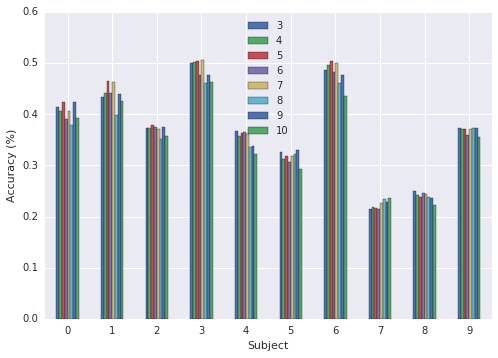

In [7]:
compare([
    Exp(name='%d' % i, root='../.cache/sigr-inter-adabn-%d-v955.75.' + str(i)) for i in range(3, 11)
])

64    0.673165
dtype: float64

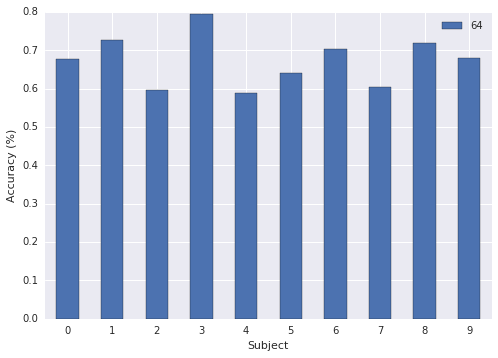

In [6]:
compare([
    Exp(name='%d' % i, root='../.cache/sigr-inter-calib-adabn-%d-v956.' + str(i)) for i in [64]
])

63    0.379970
64    0.380020
65    0.360816
66    0.366776
67    0.347065
68    0.345018
69    0.340747
dtype: float64

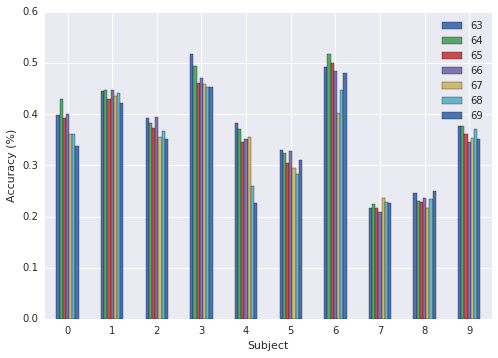

In [5]:
compare([
    Exp(name='%d' % i, root='../.cache/sigr-inter-adabn-%d-v956.' + str(i)) for i in [63, 64, 65, 66, 67, 68, 69]
])

Vote        0.549232
Chan        0.561578
LSTM        0.572717
LSTM 128    0.563237
LSTM x2     0.571632
LSTM ave    0.557998
LSTM c10    0.584711
dtype: float64

323.58913517


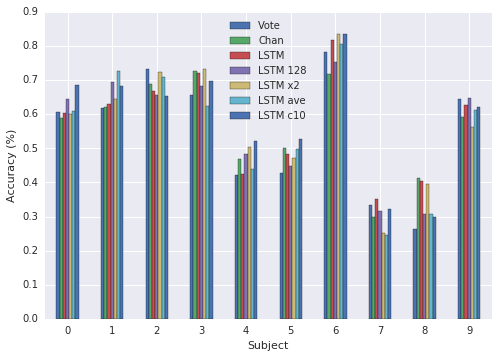

In [9]:
tic = time()
compare([
    Exp(name='Vote', dataset=s21, vote=150,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-adabn-%d-v843/model-0060.params')),
    Exp(name='Chan', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 symbol_kargs=dict(num_channel=150),
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-w150-adabn-%d-v843/model-0060.params')),
    Exp(name='LSTM', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 lstm=True,
                 num_lstm_hidden=16,
                 symbol_kargs=dict(num_channel=30, lstm_window=5, lstm_last=1),
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-w150-lstm-adabn-%d-v920/model-0060.params')),
    Exp(name='LSTM 128', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 lstm=True,
                 num_lstm_hidden=128,
                 symbol_kargs=dict(num_channel=30, lstm_window=5, lstm_last=1),
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-w150-lstm-adabn-%d-v924/model-0060.params')),
    Exp(name='LSTM x2', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 lstm=True,
                 num_lstm_hidden=16,
                 num_lstm_layer=2,
                 symbol_kargs=dict(num_channel=30, lstm_window=5, lstm_last=1),
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-w150-lstm-adabn-%d-v925/model-0060.params')),
    Exp(name='LSTM ave', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 lstm=True,
                 num_lstm_hidden=16,
                 symbol_kargs=dict(num_channel=30, lstm_window=5),
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-w150-lstm-adabn-%d-v926/model-0060.params')),
    Exp(name='LSTM c10', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 lstm=True,
                 num_lstm_hidden=16,
                 symbol_kargs=dict(num_channel=10, lstm_window=15, lstm_last=1),
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-w150-lstm-adabn-%d-v927/model-0060.params')),
])
print(time() - tic)

Baseline    0.359292
Baseline    0.362896
Simple      0.368340
ResNet      0.353429
ResNet      0.350908
dtype: float64

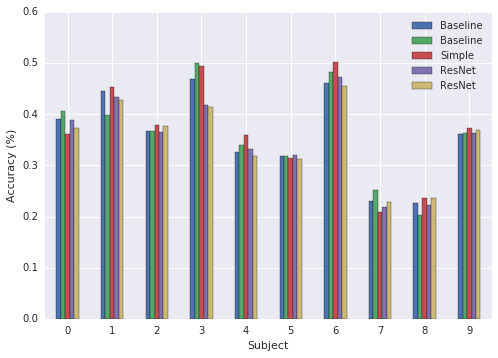

In [4]:
compare([
    Exp(name='Baseline', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-adabn-%d-v843/model-0060.params')),
    Exp(name='Baseline', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-adabn-%d-v955.74.50/model-0060.params')),
    Exp(name='Simple', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, num_pixel=0, num_filter=64),
                 params='../.cache/sigr-inter-adabn-%d-v955.28/model-0060.params')),
    Exp(name='ResNet', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, num_presnet=8,
                                   presnet_branch=[1],
                                   presnet_proj_type='B',
                                   presnet_promote=True,
                                   num_pixel=0),
                 params='../.cache/sigr-inter-adabn-%d-v955.75.1/model-0060.params')),
    Exp(name='ResNet', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, num_presnet=8,
                                   presnet_branch=[1],
                                   presnet_proj_type='B',
                                   presnet_promote=True,
                                   presnet_dense=True,
                                   num_pixel=0),
                 params='../.cache/sigr-inter-adabn-%d-v955.75.2/model-0060.params')),
])

Baseline    0.359292
Baseline    0.357956
Simple      0.368340
Shortcut    0.374144
Local       0.367111
dtype: float64

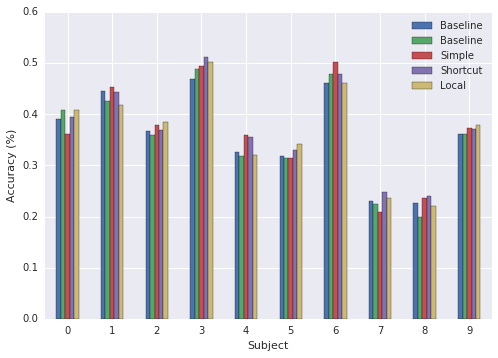

In [3]:
compare([
    Exp(name='Baseline', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-adabn-%d-v843/model-0060.params')),
    Exp(name='Baseline', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-adabn-%d-v843.1/model-0060.params')),
    Exp(name='Simple', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, num_pixel=0, num_filter=64),
                 params='../.cache/sigr-inter-adabn-%d-v955.28/model-0060.params')),
    Exp(name='Shortcut', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0,
                                   conv_shortcut=True,
                                   num_pixel=2,
                                   num_pixel_reduce_filter=(32, 64),
                                   pixel_reduce_kernel=(3, 3),
                                   pixel_reduce_pad=(1, 1),
                                   pixel_reduce_stride=(2, 2)),
                 params='../.cache/sigr-inter-adabn-%d-v956.30/model-0060.params')),
    Exp(name='Local', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0,
                                   num_pixel=2,
                                   num_pixel_reduce_filter=(32, 64),
                                   pixel_reduce_kernel=(3, 3),
                                   pixel_reduce_pad=(1, 1),
                                   pixel_reduce_stride=(2, 2)),
                 params='../.cache/sigr-inter-adabn-%d-v956.58/model-0060.params')),
])

Baseline    0.692704
Simple      0.680844
Shortcut    0.678606
ResNet      0.308481
dtype: float64

121.555298805


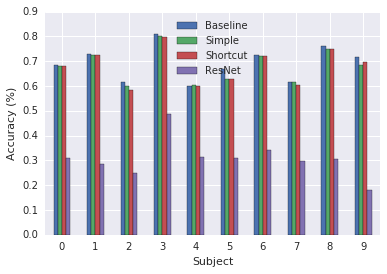

In [7]:
tic = time()
compare([
    Exp(name='Baseline', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-calib-adabn-%d-v943/model-0060.params')),
    Exp(name='Simple', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(num_pixel=0, num_filter=64),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.28/model-0060.params')),
    Exp(name='Shortcut', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0,
                                   conv_shortcut=True,
                                   num_pixel=2,
                                   num_pixel_reduce_filter=(32, 64),
                                   pixel_reduce_kernel=(3, 3),
                                   pixel_reduce_pad=(1, 1),
                                   pixel_reduce_stride=(2, 2)),
                 params='../.cache/sigr-inter-calib-adabn-%d-v956.30.2/model-0200.params')),
    Exp(name='ResNet', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, num_presnet=32, presnet_branch=[1], num_pixel=0),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.36/model-0140.params')),
])
print(time() - tic)

Baseline    0.359292
ResNet      0.385876
ResNet      0.362579
dtype: float64

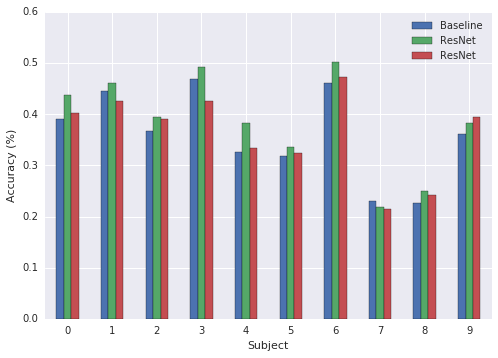

In [5]:
compare([
    Exp(name='Baseline', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-adabn-%d-v843/model-0060.params')),
#    Exp(name='Simple', dataset=s21,
#        Mod=dict(num_gesture=8,
#                 adabn=True,
#                 num_adabn_epoch=1,
#                 context=[mx.gpu(0)],
#                 symbol_kargs=dict(dropout=0, num_pixel=0, num_filter=64),
#                 params='../.cache/sigr-inter-adabn-%d-v955.28/model-0060.params')),
#    Exp(name='ResNet', dataset=s21,
#        Mod=dict(num_gesture=8,
#                 adabn=True,
#                 num_adabn_epoch=1,
#                 context=[mx.gpu(0)],
#                 symbol_kargs=dict(dropout=0, num_presnet=8, presnet_branch=[1], num_pixel=0),
#                 params='../.cache/sigr-inter-adabn-%d-v955.32/model-0060.params')),
    Exp(name='ResNet', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, num_presnet=32, presnet_branch=[1], num_pixel=0),
                 params='../.cache/sigr-inter-adabn-%d-v955.34/model-0060.params')),
    Exp(name='ResNet', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, num_presnet=8, presnet_branch=[1, 3],
                                   num_pixel=0),
                 params='../.cache/sigr-inter-adabn-%d-v955.56/model-0060.params')),
#    Exp(name='ResNet', dataset=s21,
#        Mod=dict(num_gesture=8,
#                 adabn=True,
#                 num_adabn_epoch=1,
#                 context=[mx.gpu(0)],
#                 symbol_kargs=dict(dropout=0, num_presnet=[10, 10, 10], presnet_branch=[1],
#                                   num_pixel=0, num_feature_block=0),
#                 params='../.cache/sigr-inter-adabn-%d-v955.51/model-0060.params')),
#    Exp(name='LResNet', dataset=s21,
#        Mod=dict(num_gesture=8,
#                 adabn=True,
#                 num_adabn_epoch=1,
#                 context=[mx.gpu(0)],
#                 symbol_kargs=dict(dropout=0, num_presnet=[4, 4, 4], presnet_branch=[1, 3],
#                                   num_pixel=0, num_feature_block=0),
#                 params='../.cache/sigr-inter-adabn-%d-v955.50/model-0060.params')),
#    Exp(name='ResNet', dataset=s21,
#        Mod=dict(num_gesture=8,
#                 adabn=True,
#                 num_adabn_epoch=1,
#                 context=[mx.gpu(0)],
#                 symbol_kargs=dict(num_presnet=32, presnet_branch=[1]),
#                 params='../.cache/sigr-inter-adabn-%d-v955.5/model-0060.params')),
])

Baseline    0.360230
Faug        0.356908
dtype: float64

122.701521873


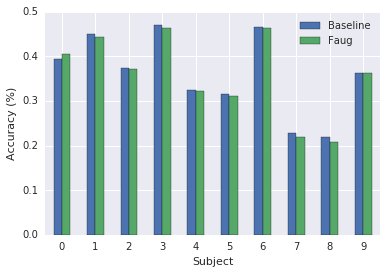

In [29]:
compare([
    Exp(name='Baseline', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-adabn-%d-v843/model-0060.params')),
    Exp(name='Faug', dataset=s21,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-faug-adabn-%d-v941/model-0060.params')),
])
compare([
    Exp(name='Baseline', dataset=s21, vote=150,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-adabn-%d-v843/model-0060.params')),
    Exp(name='Faug', dataset=s21, vote=150,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-faug-adabn-%d-v941/model-0060.params')),
])

In [ ]:
tic = time()
compare([
    Exp(name='Baseline', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-calib-adabn-%d-v943/model-0060.params')),
    Exp(name='Faug', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-calib-faug-adabn-%d-v952/model-0060.params')),
#    Exp(name='Simple', dataset=s21, calib=True,
#        Mod=dict(num_gesture=8,
#                 adabn=True,
#                 num_adabn_epoch=1,
#                 context=[mx.gpu(0)],
#                 symbol_kargs=dict(num_pixel=0, num_filter=64, dropout=0),
#                 params='../.cache/sigr-inter-calib-adabn-%d-v955.28/model-0060.params')),
#    Exp(name='ResNet', dataset=s21, calib=True,
#        Mod=dict(num_gesture=8,
#                 adabn=True,
#                 num_adabn_epoch=1,
#                 context=[mx.gpu(0)],
#                 symbol_kargs=dict(num_presnet=32, presnet_branch=[1], dropout=0),
#                 params='../.cache/sigr-inter-calib-adabn-%d-v955.5/model-0060.params')),
    Exp(name='ResNet', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, num_presnet=32, presnet_branch=[1], num_pixel=0),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.36/model-0140.params')),
    Exp(name='ResNet', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, num_presnet=8, presnet_branch=[1, 3],
                                   num_pixel=0),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.56/model-0060.params')),
#    Exp(name='ResNet faug', dataset=s21, calib=True,
#        Mod=dict(num_gesture=8,
#                 adabn=True,
#                 num_adabn_epoch=1,
#                 context=[mx.gpu(0)],
#                 symbol_kargs=dict(dropout=0, num_presnet=32, presnet_branch=[1], num_pixel=0),
#                 params='../.cache/sigr-inter-calib-faug-adabn-%d-v955.36/model-0140.params')),
#    Exp(name='ResNet', dataset=s21, calib=True,
#        Mod=dict(num_gesture=8,
#                 adabn=True,
#                 num_adabn_epoch=1,
#                 context=[mx.gpu(0)],
#                 symbol_kargs=dict(dropout=0, num_presnet=[10, 10, 10], presnet_branch=[1],
#                                   num_pixel=0, num_feature_block=0),
#                 params='../.cache/sigr-inter-calib-adabn-%d-v955.51/model-0140.params')),
])
print(time() - tic)

Baseline        0.692704
Baseline        0.694269
Simple          0.680844
Local           0.674592
Local           0.685406
Local           0.686787
Local bottle    0.667306
dtype: float64

116.034829855


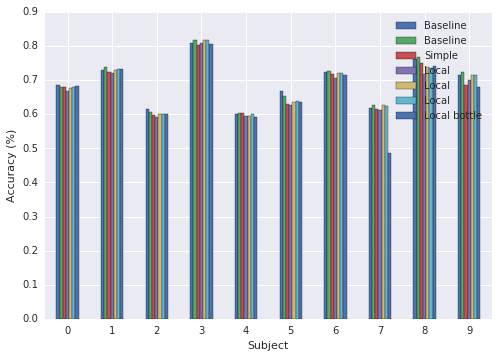

In [5]:
tic = time()
compare([
    Exp(name='Baseline', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-calib-adabn-%d-v943/model-0060.params')),
    Exp(name='Baseline', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.74.50/model-0060.params')),
    Exp(name='Simple', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(num_pixel=0, num_filter=64),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.28/model-0060.params')),
    Exp(name='Local', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0,
                                   num_pixel=4,
                                   num_pixel_reduce_filter=(32, 32, 64, 64),
                                   pixel_reduce_kernel=(3, 3, 3, 3),
                                   pixel_reduce_pad=(1, 1, 1, 1),
                                   pixel_reduce_stride=(2, 1, 2, 1)),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.74.41/model-0060.params')),
    Exp(name='Local', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0,
                                   num_filter=32,
                                   num_pixel=4,
                                   num_pixel_reduce_filter=(64, 64, 128, 128),
                                   pixel_reduce_kernel=(3, 3, 3, 3),
                                   pixel_reduce_pad=(1, 1, 1, 1),
                                   pixel_reduce_stride=(2, 1, 2, 1)),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.74.47/model-0060.params')),
    Exp(name='Local', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0,
                                   num_filter=32,
                                   num_pixel=4,
                                   num_pixel_reduce_filter=(64, 64, 128, 128),
                                   pixel_reduce_kernel=(3, 3, 3, 3),
                                   pixel_reduce_pad=(1, 1, 1, 1),
                                   pixel_reduce_stride=(2, 1, 2, 1)),
                 params='../.cache/sigr-inter-calib-adabn-%d-v956.5/model-0060.params')),
    Exp(name='Local bottle', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0,
                                   num_pixel=4,
                                   num_pixel_reduce_filter=(32, 32, 64, 64),
                                   pixel_reduce_kernel=(3, 1, 3, 1),
                                   pixel_reduce_pad=(1, 0, 1, 0),
                                   pixel_reduce_stride=(2, 1, 2, 1)),
                 params='../.cache/sigr-inter-calib-adabn-%d-v956.9/model-0060.params')),
])
print(time() - tic)

Baseline    0.692704
Simple      0.680844
Local       0.678796
Local       0.685010
Local       0.685467
dtype: float64

115.602231979


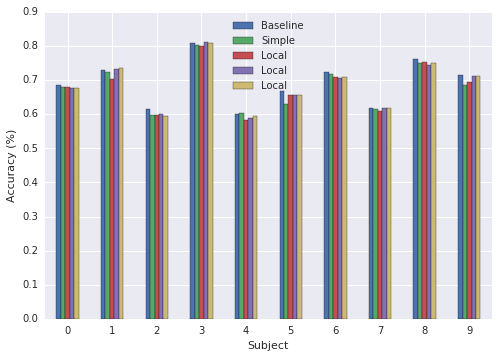

In [7]:
tic = time()
compare([
    Exp(name='Baseline', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-calib-adabn-%d-v943/model-0060.params')),
    Exp(name='Simple', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(num_pixel=0, num_filter=64),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.28/model-0060.params')),
    Exp(name='Local', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.70.6/model-0060.params')),
    Exp(name='Local', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, pixel_reduce_kernel=3),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.74.8/model-0060.params')),
    Exp(name='Local', dataset=s21, calib=True,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, pixel_reduce_kernel=3),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.74.9/model-0140.params')),
])
print(time() - tic)

Vote             0.902130
Faug finetune    0.911276
Simple           0.896651
ResNet           0.896191
dtype: float64

255.460939884


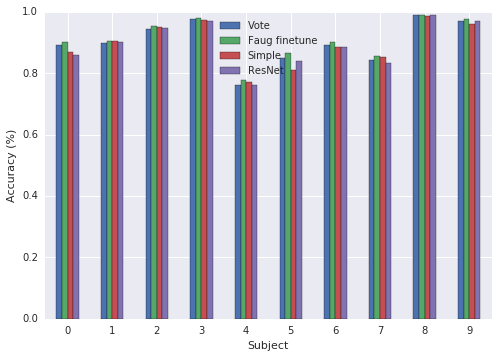

In [17]:
tic = time()
compare([
    Exp(name='Vote', dataset=s21, calib=True, vote=150,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-calib-adabn-%d-v943/model-0060.params')),
    Exp(name='Faug finetune', dataset=s21, calib=True, vote=150,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 params='../.cache/sigr-inter-calib-faug-adabn-%d-v952/model-0060.params')),
    Exp(name='Simple', dataset=s21, calib=True, vote=150,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(num_pixel=0, num_filter=64),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.28/model-0060.params')),
    Exp(name='ResNet', dataset=s21, calib=True, vote=150,
        Mod=dict(num_gesture=8,
                 adabn=True,
                 num_adabn_epoch=1,
                 context=[mx.gpu(0)],
                 symbol_kargs=dict(dropout=0, num_presnet=32, presnet_branch=[1], num_pixel=0),
                 params='../.cache/sigr-inter-calib-adabn-%d-v955.36/model-0140.params')),
])
print(time() - tic)

150     0.560753
v924    0.559515
v925    0.569702
v926    0.557769
v927    0.583887
v930    0.453524
v939    0.571702
v940    0.568455
dtype: float64

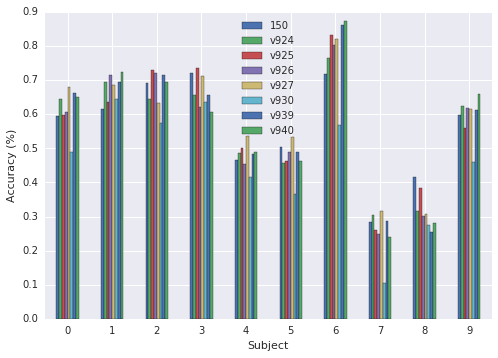

In [31]:
compare([
    Exp(name='150', root='../.cache/sigr-inter-w150-adabn-%d-v843'),
    Exp(name='v924', root='../.cache/sigr-inter-w150-lstm-adabn-%d-v924'),
    Exp(name='v925', root='../.cache/sigr-inter-w150-lstm-adabn-%d-v925'),
    Exp(name='v926', root='../.cache/sigr-inter-w150-lstm-adabn-%d-v926'),
    Exp(name='v927', root='../.cache/sigr-inter-w150-lstm-adabn-%d-v927'),
    Exp(name='v930', root='../.cache/sigr-inter-w150-lstm-adabn-%d-v930'),
    Exp(name='v939', root='../.cache/sigr-inter-w150-faug-lstm-adabn-%d-v939'),
    Exp(name='v940', root='../.cache/sigr-inter-w150-faug-lstm-adabn-%d-v940'),
])

v927    0.820351
aug     0.822845
v932    0.864392
v933    0.871137
v936    0.899791
dtype: float64

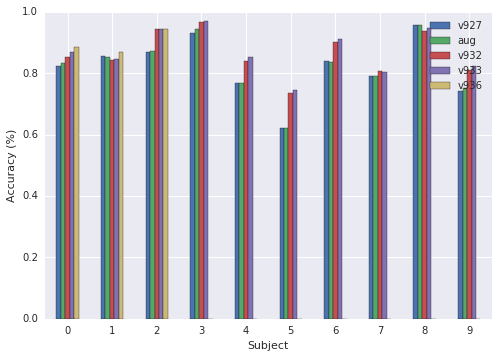

In [26]:
compare([
    Exp(name='v927', root='../.cache/sigr-inter-calib-w150-lstm-adabn-%d-v927'),
    Exp(name='aug', root='../.cache/sigr-inter-calib-w150-aug-lstm-adabn-%d-v927'),
    Exp(name='v932', root='../.cache/sigr-inter-calib-w150-lstm-adabn-%d-v932'),
    Exp(name='v933', root='../.cache/sigr-inter-calib-w150-faug-lstm-adabn-%d-v933'),
    #Exp(name='v934', root='../.cache/sigr-inter-calib-w150-faug-lstm-adabn-%d-v934'),
    #Exp(name='v935', root='../.cache/sigr-inter-calib-w150-faug-lstm-adabn-%d-v935'),
    Exp(name='v936', root='../.cache/sigr-inter-calib-w150-faug-lstm-adabn-%d-v936'),
    #Exp(name='v937', root='../.cache/sigr-inter-calib-w150-faug-lstm-adabn-%d-v937'),
    #Exp(name='v938', root='../.cache/sigr-inter-calib-w150-lstm-adabn-%d-v938'),
])

No adaptation         0.315367
RevGrad               0.314499
Tzeng                 0.318162
Tzeng 0.1             0.323800
AdaBN                 0.359597
AdaBN + Tzeng         0.359083
AdaBN + Tzeng 0.1     0.359262
AdaBN + Tzeng m0.1    0.363057
AdaBN + Tzeng all     0.361461
dtype: float64

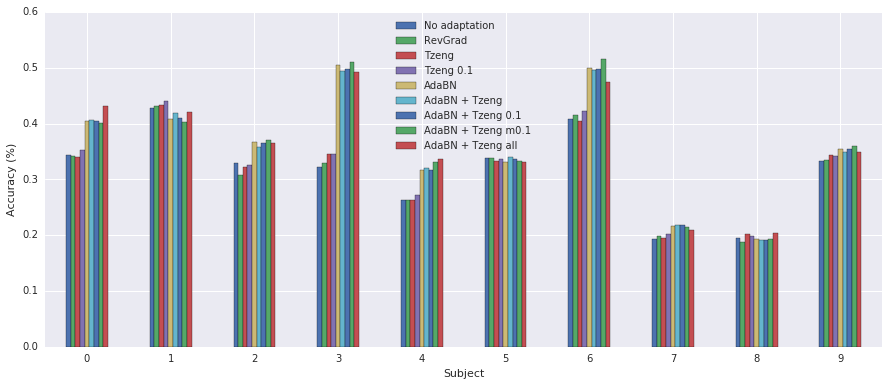

In [53]:
compare([
    ('No adaptation', '../.cache/sigr-inter-%d-v411'),
    ('RevGrad', '../.cache/sigr-inter-revgrad-%d-v508'),
    ('Tzeng', '../.cache/sigr-inter-tzeng-%d-v507'),
    ('Tzeng 0.1', '../.cache/sigr-inter-tzeng-%d-v509'),
    #('AdaBN', '../.cache/sigr-inter-adabn-%d-v411'),
    ('AdaBN', '../.cache/sigr-inter-adabn-%d-v506'),
    ('AdaBN + Tzeng', '../.cache/sigr-inter-adabn-tzeng-%d-v507'),
    ('AdaBN + Tzeng 0.1', '../.cache/sigr-inter-adabn-tzeng-%d-v510'),
    ('AdaBN + Tzeng m0.1', '../.cache/sigr-inter-adabn-tzeng-%d-v511'),
    ('AdaBN + Tzeng all', '../.cache/sigr-inter-adabn-tzeng-%d-v512'),
])
plt.gcf().set_size_inches(15, 6)

No adaptation    0.315367
AdaBN            0.359597
v521             0.365135
v522             0.361618
v523             0.362021
v525             0.313483
v600             0.363851
v604             0.315629
v605             0.314850
v606             0.318400
v608             0.417167
dtype: float64

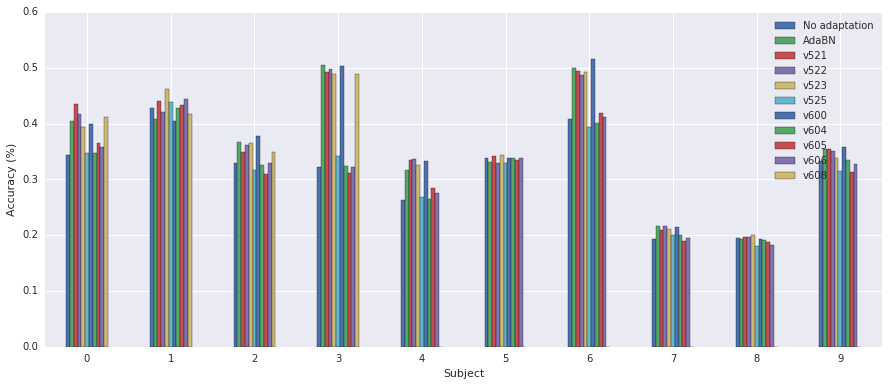

In [23]:
compare([
    ('No adaptation', '../.cache/sigr-inter-%d-v411'),
    ('AdaBN', '../.cache/sigr-inter-adabn-%d-v506'),
    ('v521', '../.cache/sigr-inter-adabn-tzeng-%d-v521'),
    ('v522', '../.cache/sigr-inter-adabn-tzeng-%d-v522'),
    ('v523', '../.cache/sigr-inter-adabn-tzeng-%d-v523'),
    #('v524', '../.cache/sigr-inter-tzeng-%d-v524'),
    ('v525', '../.cache/sigr-inter-tzeng-%d-v525'),
    #('v526', '../.cache/sigr-inter-adabn-tzeng-%d-v526'),
    #('v527', '../.cache/sigr-inter-adabn-tzeng-%d-v527'),
    #('v528', '../.cache/sigr-inter-tzeng-%d-v528'),
    #('v529', '../.cache/sigr-inter-adabn-tzeng-%d-v529'),
    ('v600', '../.cache/sigr-inter-adabn-tzeng-%d-v600'),
    ('v604', '../.cache/sigr-inter-tzeng-%d-v604'),
    ('v605', '../.cache/sigr-inter-tzeng-%d-v605'),
    ('v606', '../.cache/sigr-inter-tzeng-%d-v606'),
    ('v608', '../.cache/sigr-inter-adabn-revgrad-%d-v608'),
    #('v512', '../.cache/sigr-inter-adabn-revgrad-%d-v512')
])
plt.gcf().set_size_inches(15, 6)

No adaptation    0.315367
AdaBN            0.359597
v521             0.365135
v702             0.363142
v737             0.317296
v811             0.357491
v818             0.358267
dtype: float64

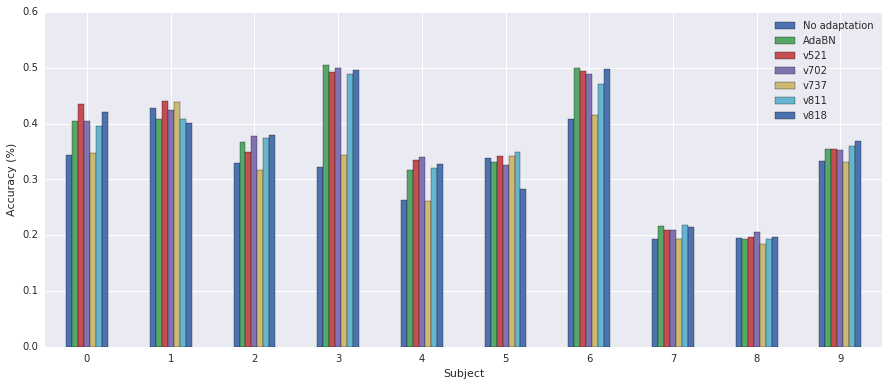

In [4]:
compare([
    ('No adaptation', '../.cache/sigr-inter-%d-v411'),
    ('AdaBN', '../.cache/sigr-inter-adabn-%d-v506'),
    ('v521', '../.cache/sigr-inter-adabn-tzeng-%d-v521'),
    ('v702', '../.cache/sigr-inter-adabn-revgrad-%d-v702'),
    #('v703', '../.cache/sigr-inter-adabn-revgrad-%d-v703'),
    #('v705', '../.cache/sigr-inter-adabn-revgrad-%d-v705'),
    #('v732', '../.cache/sigr-inter-adabn-revgrad-%d-v732'),
    #('v734', '../.cache/sigr-inter-adabn-revgrad-%d-v734'),
    #('v735', '../.cache/sigr-inter-adabn-revgrad-%d-v735'),
    ('v737', '../.cache/sigr-inter-revgrad-%d-v737'),
    ('v811', '../.cache/sigr-inter-adabn-%d-v811'),
    #('v813', '../.cache/sigr-inter-adabn-%d-v813'),
    ('v818', '../.cache/sigr-inter-adabn-revgrad-%d-v818'),
])
plt.gcf().set_size_inches(15, 6)

No adaptation    0.314998
v843             0.358345
v838             0.318209
v838             0.345544
v843             0.313543
v843             0.348270
augscale         0.350132
augbad           0.353484
dtype: float64

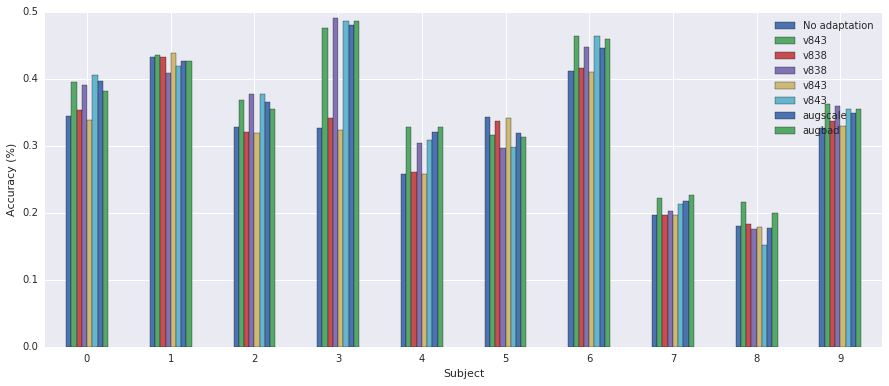

In [13]:
compare([
    #('No adaptation', '../.cache/sigr-inter-%d-v411'),
    ('No adaptation', '../.cache/sigr-inter-%d-v843'),
    #('v811', '../.cache/sigr-inter-adabn-%d-v811'),
    ('v843', '../.cache/sigr-inter-adabn-%d-v843'),
    #('v818', '../.cache/sigr-inter-adabn-revgrad-%d-v818'),
    #('v819', '../.cache/sigr-inter-adabn-revgrad-%d-v819'),
    #('v821', '../.cache/sigr-inter-adabn-tzeng-%d-v821'),
    #('v824', '../.cache/sigr-inter-adabn-tzeng-%d-v824'),
    #('v837', '../.cache/sigr-inter-adabn-tzeng-%d-v837'),
    #('v834', '../.cache/sigr-inter-adabn-tzeng-%d-v834'),
    ('v838', '../.cache/sigr-inter-tzeng-%d-v838'),
    ('v838', '../.cache/sigr-inter-adabn-tzeng-%d-v838'),
    #('v839', '../.cache/sigr-inter-tzeng-%d-v839'),
    #('v839', '../.cache/sigr-inter-adabn-tzeng-%d-v839'),
    #('v840', '../.cache/sigr-inter-tzeng-%d-v840'),
    #('v840', '../.cache/sigr-inter-adabn-tzeng-%d-v840'),
    ('v843', '../.cache/sigr-inter-revgrad-%d-v843'),
    ('v843', '../.cache/sigr-inter-adabn-revgrad-%d-v843'),
    ('augscale', '../.cache/sigr-inter-augscale-adabn-%d-v843'),
    ('augbad', '../.cache/sigr-inter-augbad-adabn-%d-v843'),
])
plt.gcf().set_size_inches(15, 6)

No adaptation      0.303673
Tzeng              0.310993
RevGrad            0.303386
AdaBN              0.360081
AdaBN + Tzeng      0.346860
AdaBN + RevGrad    0.349544
dtype: float64

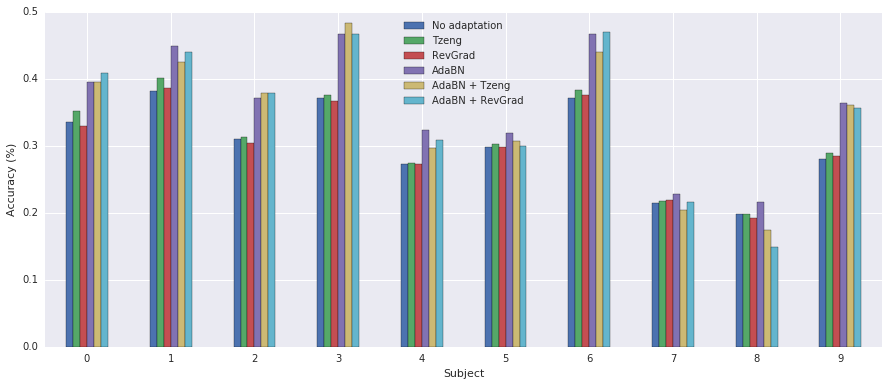

In [8]:
compare([
    ('No adaptation', '../.cache/sigr-inter-%d-v843', 60),
    #Exp(name='v821', root='../.cache/sigr-inter-adabn-tzeng-%d-v821', num_iter=60),
    #Exp(name='v834', root='../.cache/sigr-inter-adabn-tzeng-%d-v834', num_iter=10),
    #Exp(name='v837', root='../.cache/sigr-inter-adabn-tzeng-%d-v837', num_iter=10),
    #Exp(name='v839', root='../.cache/sigr-inter-adabn-tzeng-%d-v839', num_iter=60),
    #Exp(name='v840', root='../.cache/sigr-inter-adabn-tzeng-%d-v840', num_iter=60),
    ('Tzeng', '../.cache/sigr-inter-tzeng-%d-v838', 60),
    ('RevGrad', '../.cache/sigr-inter-revgrad-%d-v843', 60),
    ('AdaBN', '../.cache/sigr-inter-adabn-%d-v843', 60),
    ('AdaBN + Tzeng', '../.cache/sigr-inter-adabn-tzeng-%d-v838', 60),
    ('AdaBN + RevGrad', '../.cache/sigr-inter-adabn-revgrad-%d-v843', 60),
])
plt.gcf().set_size_inches(15, 6)

No adaptation      0.307057
Tzeng              0.311245
RevGrad            0.303488
AdaBN              0.358806
AdaBN + Tzeng      0.345971
AdaBN + RevGrad    0.350772
dtype: float64

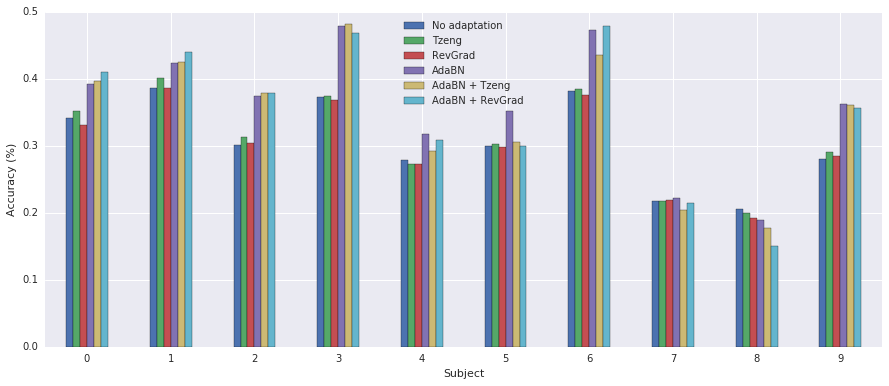

In [52]:
compare([
    ('No adaptation', '../.cache/sigr-inter-%d-v411', 60),
    #Exp(name='v821', root='../.cache/sigr-inter-adabn-tzeng-%d-v821', num_iter=60),
    #Exp(name='v834', root='../.cache/sigr-inter-adabn-tzeng-%d-v834', num_iter=10),
    #Exp(name='v837', root='../.cache/sigr-inter-adabn-tzeng-%d-v837', num_iter=10),
    #Exp(name='v839', root='../.cache/sigr-inter-adabn-tzeng-%d-v839', num_iter=60),
    #Exp(name='v840', root='../.cache/sigr-inter-adabn-tzeng-%d-v840', num_iter=60),
    ('Tzeng', '../.cache/sigr-inter-tzeng-%d-v838', 60),
    ('RevGrad', '../.cache/sigr-inter-revgrad-%d-v843', 60),
    ('AdaBN', '../.cache/sigr-inter-adabn-%d-v811', 60),
    ('AdaBN + Tzeng', '../.cache/sigr-inter-adabn-tzeng-%d-v838', 60),
    ('AdaBN + RevGrad', '../.cache/sigr-inter-adabn-revgrad-%d-v843', 60),
])
plt.gcf().set_size_inches(15, 6)

AdaBN    0.700258
dtype: float64

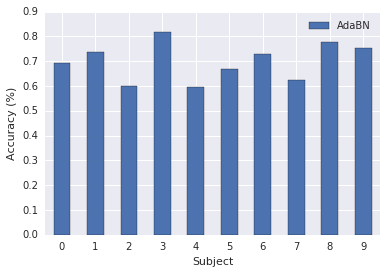

In [9]:
compare([
    ('AdaBN', '../.cache/sigr-inter-calib-adabn-%d-v843', 15, True),
])

150        0.560753
fft bng    0.575480
dual       0.578244
concat     0.522514
v920       0.521148
dtype: float64

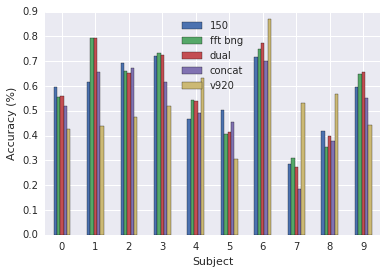

In [14]:
compare([
    ('150', '../.cache/sigr-inter-w150-adabn-%d-v843'),
    #('fft', '../.cache/sigr-inter-w150-fft-adabn-%d-v844'),
    ('fft bng', '../.cache/sigr-inter-w150-fft-adabn-%d-v845'),
    ('dual', '../.cache/sigr-inter-w150-dual-adabn-%d-v847'),
    #('aug dual', '../.cache/sigr-inter-w150-aug-dual-adabn-%d-v847'),
    ('concat', '../.cache/sigr-inter-w150-fftappend-adabn-%d-v845'),
    #('v862', '../.cache/sigr-inter-w150-lstm-adabn-%d-v862'),
    #('v863', '../.cache/sigr-inter-w150-lstm-adabn-%d-v863'),
    #('v868', '../.cache/sigr-inter-w150-lstm-adabn-%d-v868'),
    ('v920', '../.cache/sigr-inter-w150-lstm-adabn-%d-v920'),
])

150         0.792008
150 aug     0.784892
150 aug2    0.785132
150 aug2    0.793490
dtype: float64

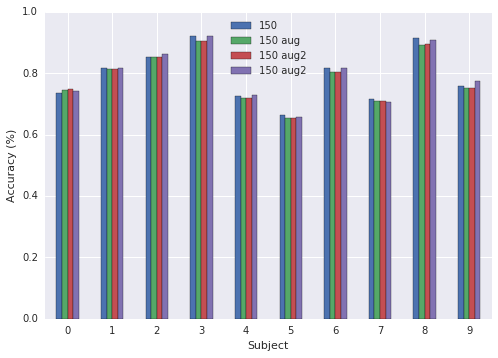

In [17]:
compare([
    ('150', '../.cache/sigr-inter-calib-w150-adabn-%d-v844'),
    ('150 aug', '../.cache/sigr-inter-calib-w150-augscale-adabn-%d-v843'),
    ('150 aug2', '../.cache/sigr-inter-calib-w150-augscale2-adabn-%d-v843'),
    ('150 aug2', '../.cache/sigr-inter-calib-w150-augscale2-adabn-%d-v844'),
])

No adaptation    0.315367
AdaBN            0.351507
dtype: float64

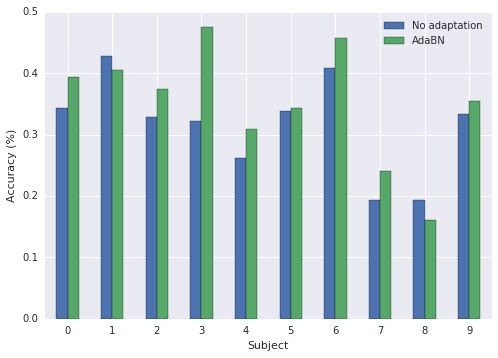

In [6]:
compare([
    ('No adaptation', '../.cache/sigr-inter-%d-v411'),
    ('AdaBN', '../.cache/sigr-inter-adabn-%d-v411'),
])

No adaptation    0.313776
AdaBN            0.323866
dtype: float64

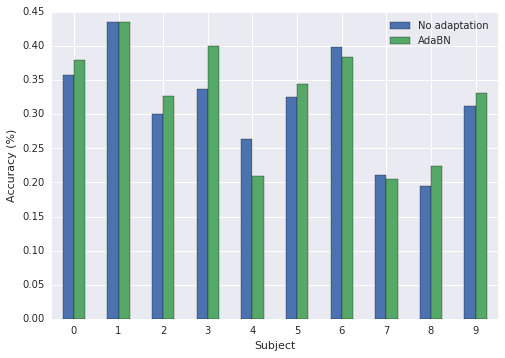

In [7]:
compare([
    ('No adaptation', '../.cache/sigr-inter-%d-v412'),
    ('AdaBN', '../.cache/sigr-inter-adabn-%d-v412'),
])

No adaptation    0.355991
AdaBN            0.412587
AdaBN + Tzeng    0.325572
dtype: float64

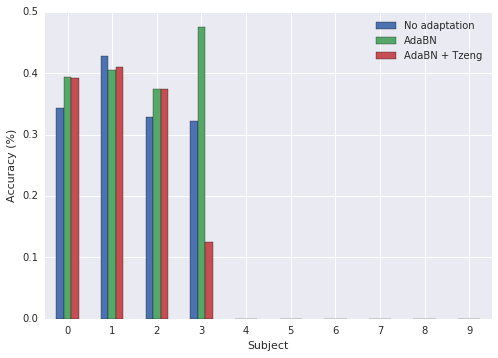

In [8]:
compare([
    ('No adaptation', '../.cache/sigr-inter-%d-v411'),
    ('AdaBN', '../.cache/sigr-inter-adabn-%d-v411'),
    ('AdaBN + Tzeng', '../.cache/sigr-inter-adabn-tzeng-%d-v413'),
])

Without adaptation    0.323111
With adaptation       0.353209
dtype: float64

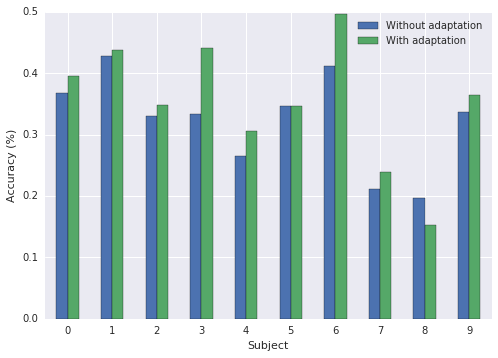

In [32]:
compare([
    ('Without adaptation', '../.cache/sigr-inter-%d-v403'),
    ('With adaptation', '../.cache/sigr-inter-adabn-%d-v403')
])

Without adaptation    0.336452
With adaptation       0.329877
dtype: float64

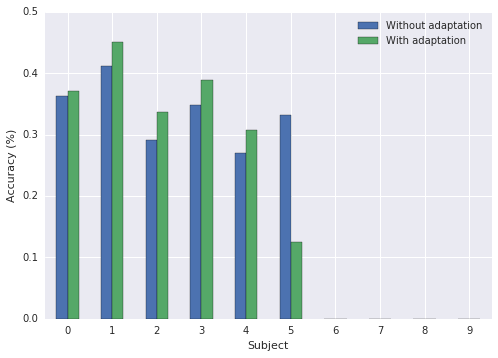

In [22]:
roots = [
    '../.cache/sigr-inter-%d-v404',
    '../.cache/sigr-inter-adabn-%d-v404'
]
df = []
for fold in range(10):
    try:
        df.append([parse_log((r + '/log') % fold).val.iloc[-1] for r in roots])
    except:
        df.append([np.nan, np.nan])
df = pd.DataFrame(df, columns=['Without adaptation', 'With adaptation'])
df.plot.bar(rot=0)
plt.xlabel('Subject')
plt.ylabel('Accuracy (%)')
df.mean()

Without adaptation    0.310171
With adaptation       0.340309
dtype: float64

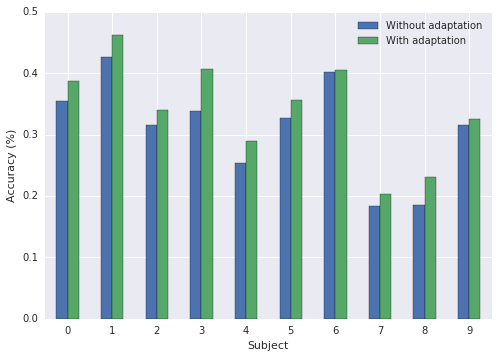

In [15]:
roots = [
    '../.cache/sigr-inter-%d-v353',
    '../.cache/sigr-inter-adabn-%d-v398'
]
df = []
for fold in range(10):
    df.append([parse_log((r + '/log') % fold).val.iloc[-1] for r in roots])
df = pd.DataFrame(df, columns=['Without adaptation', 'With adaptation'])
df.plot.bar(rot=0)
plt.xlabel('Subject')
plt.ylabel('Accuracy (%)')
df.mean()

Without adaptation    0.310171
With adaptation       0.332012
Vote                  0.403073
dtype: float64

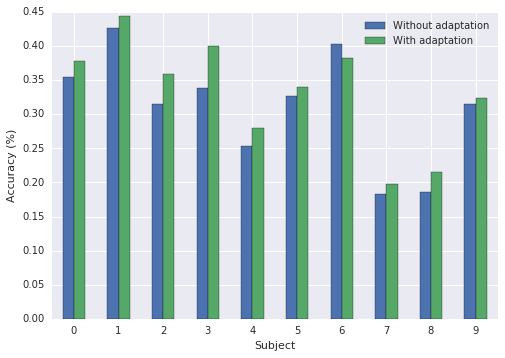

In [6]:
df = []
for fold in range(10):
    log_df = parse_log('../.cache/sigr-inter-%d-v353/log' % fold)
    #log_adabn_df = parse_log('../.cache/sigr-inter-adabn-%d-v353/log' % fold)
    acc, vacc = get_score('../.cache/sigr-inter-adabn-%d-v353/model-0060.params', fold)
    df.append([log_df.val.iloc[-1], acc, vacc])
df = pd.DataFrame(df, columns=['Without adaptation', 'With adaptation', 'Vote'])
df.iloc[:, [0, 1]].plot.bar(rot=0)
plt.xlabel('Subject')
plt.ylabel('Accuracy (%)')
#plt.savefig('../.cache/figures/hdsemg-loso-bar.png', dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)
df.mean()

Without adaptation    0.332166
With adaptation       0.350281
Vote                  0.430046
dtype: float64

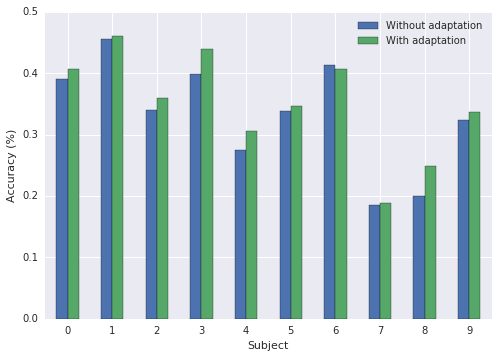

In [7]:
df = []
for fold in range(10):
    log_df = parse_log('../.cache/sigr-inter-aug-%d-v353/log' % fold)
    #log_adabn_df = parse_log('../.cache/sigr-inter-aug-adabn-%d-v353/log' % fold)
    acc, vacc = get_score('../.cache/sigr-inter-aug-adabn-%d-v353/model-0060.params', fold)
    df.append([log_df.val.iloc[-1], acc, vacc])
df = pd.DataFrame(df, columns=['Without adaptation', 'With adaptation', 'Vote'])
df.iloc[:, [0, 1]].plot.bar(rot=0)
plt.xlabel('Subject')
plt.ylabel('Accuracy (%)')
df.mean()

No augmentation      0.690280
With augmentation    0.688875
From augmentation    0.689176
dtype: float64

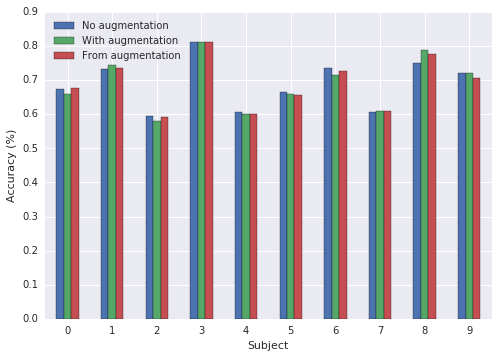

In [10]:
roots = [
    '../.cache/sigr-inter-calib-adabn-%d-v392',
    '../.cache/sigr-inter-aug-calib-adabn-%d-v392',
    '../.cache/sigr-inter-fromaug-calib-adabn-%d-v392'
]
df = []
for fold in range(10):
    df.append([parse_log((r + '/log') % fold).val.iloc[-1] for r in roots])
df = pd.DataFrame(df, columns=['No augmentation', 'With augmentation', 'From augmentation'])
df.plot.bar(rot=0)
plt.xlabel('Subject')
plt.ylabel('Accuracy (%)')
df.mean()

In [14]:
df = []
for fold in range(10):
    acc, vacc = get_score('../.cache/sigr-inter-calib-adabn-%d-v392/model-0020.params', fold)
    df.append([acc, vacc])
df = pd.DataFrame(df, columns=['Single frame', 'Vote'])
df.mean()

Single frame    0.721784
Vote            0.901597
dtype: float64